# Loading LSTM from training notebook

In [1]:
import torch
import pickle

import sys
sys.path.append('../')  # Go up to src/ directory
from models import LSTM_model

model = LSTM_model(input_size=14)  # 14 features now (was 9)
model.load_state_dict(torch.load('lstm_model.pth'))
scaler_X, scaler_y = pickle.load(open('scalers.pkl', 'rb'))

# Evaluate and plot

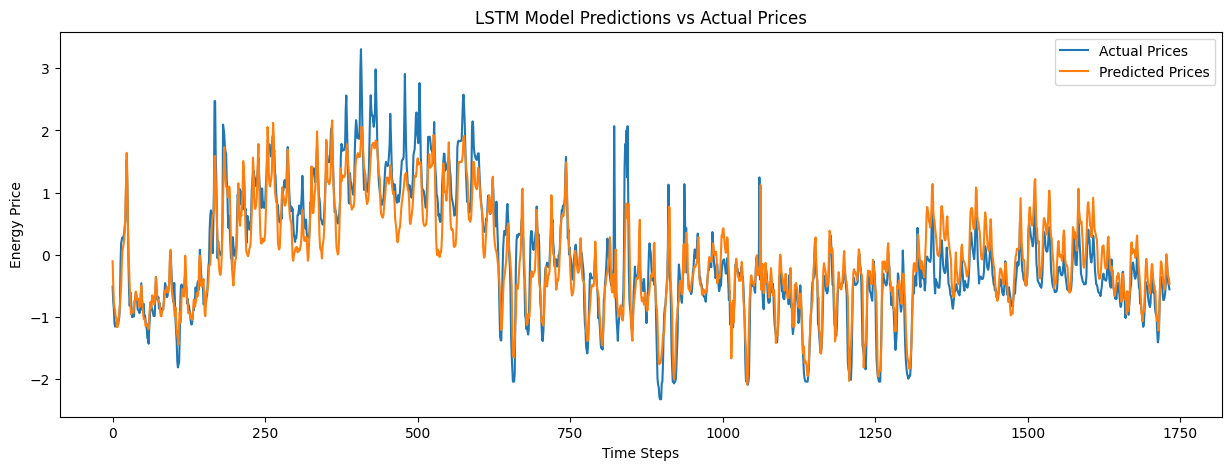

In [2]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

from dataset import EnergyPriceDataset, load_and_preprocess_energy_data

df = load_and_preprocess_energy_data('../../data/energy_data.csv')

feature_cols = [
    'Hour', 'day_nr', 'week_nr', 'year', 'month',
    'day_of_year_sin', 'day_of_year_cos',
    'wind_forecast_dah_mw', 'consumption_forecast_dah_mw',
    'temp_forecast_dah_celcius', 'temp_norm_celcius',
    'heating_demand_interaction', 'temp_deviation',
    'spot_lag1'
]
target_col = 'spot'

split_idx = int(len(df) * 0.8)
train_df = df[:split_idx]
test_df = df[split_idx:]

test_features = scaler_X.transform(test_df[feature_cols])
test_targets = scaler_y.transform(test_df[[target_col]])

sequence_length = 24 # 24 = one day, 168 = one week
test_dataset = EnergyPriceDataset(test_features, test_targets, sequence_length)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = model(X_batch)
        predictions.extend(pred.squeeze().tolist())
        actuals.extend(y_batch.tolist())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(actuals, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title('LSTM Model Predictions vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Energy Price')
plt.show()

# Tuning the hyperparameters

In [8]:
# Check if tuned parameters already exist
import os
import json
predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

from tune_hyperparameters import tune_hyperparameters
params_file = 'tuned_params.json'

if os.path.exists(params_file):
    print(f"Loading existing parameters from {params_file}")
    with open(params_file, 'r') as f:
        tuned_params = json.load(f)
    best_params_basic = tuned_params['basic']
    best_params_cutoff = tuned_params['cutoff']
else:
    print("No existing parameters found. Running hyperparameter tuning...")
    best_params_basic,best_params_cutoff = tune_hyperparameters(predictions_unscaled, actuals_unscaled, n_trials=10000, save_path=params_file)

Loading existing parameters from tuned_params.json


## OGD on the output

In [10]:
from OGD import OGD_Predictor

ogd = OGD_Predictor(alpha=0.1, eta=best_params_basic['eta'], q_init=best_params_basic['q_init'])

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = ogd.get_interval(y_pred)
    covered = ogd.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * ogd.q
        threshold = ogd.q
        
    if t % 100 == 0:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

    if t == len(predictions_unscaled) - 1:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

print("\n ")
print(f"Coverage Rate: {ogd.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {ogd.q:.2f}")
print(f"Average Width: {np.mean(ogd.threshold_history)*2:.2f}")
print(f"Median Width: {np.median(np.array(ogd.threshold_history))*2:.2f}")

misses = sum(1 for c in ogd.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(ogd.coverage_history)}")

t=0: [136.04, 226.71], pred=181.37, true=143.37, covered=True, q=45.34
t=100: [99.77, 137.94], pred=118.85, true=120.30, covered=True, q=19.09
t=200: [110.12, 232.29], pred=171.21, true=189.85, covered=True, q=61.09
t=300: [151.47, 252.64], pred=202.06, true=218.50, covered=True, q=50.59
t=400: [275.14, 397.31], pred=336.22, true=386.37, covered=True, q=61.09
t=500: [259.94, 413.61], pred=336.78, true=369.32, covered=True, q=76.84
t=600: [248.62, 391.79], pred=320.20, true=344.11, covered=True, q=71.58
t=700: [76.48, 209.15], pred=142.81, true=166.65, covered=True, q=66.33
t=800: [40.76, 110.43], pred=75.60, true=55.45, covered=True, q=34.83
t=900: [-27.93, 115.24], pred=43.65, true=-1.68, covered=True, q=71.58
t=1000: [174.42, 286.09], pred=230.26, true=181.26, covered=True, q=55.83
t=1100: [110.55, 180.22], pred=145.39, true=124.52, covered=True, q=34.83
t=1200: [144.03, 203.20], pred=173.62, true=167.05, covered=True, q=29.58
t=1300: [31.57, 132.74], pred=82.15, true=32.58, covered=

# ECI on output

In [21]:
from OGD import ECI_Predictor

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

eci_basic = ECI_Predictor(alpha=0.1, eta=best_params_basic['eta'], q_init=best_params_basic['q_init'], c=best_params_basic['c'], version='basic', eq_function=best_params_basic['eq_function'])

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = eci_basic.get_interval(y_pred)
    covered = eci_basic.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci_basic.q
        threshold = eci_basic.q
        
    if t % 100 == 0:
        lower, upper = eci_basic.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_basic.q:.2f}")
    
    if t == len(predictions_unscaled) - 1:
        lower, upper = eci_basic.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_basic.q:.2f}")
print("\n ")
print(f"Coverage Rate: {eci_basic.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Prediction length: {len(eci_basic.coverage_history)}")
print(f"Final Threshold: {eci_basic.q:.2f}")
print(f"Average Width: {np.mean(eci_basic.threshold_history)*2:.2f}")
print(f"Median Width: {np.median(np.array(eci_basic.threshold_history))*2:.2f}")

misses = sum(1 for c in eci_basic.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci_basic.coverage_history)}")

t=0: [136.04, 226.71], pred=181.37, true=143.37, covered=True, q=45.34
t=100: [105.94, 131.77], pred=118.85, true=120.30, covered=True, q=12.92
t=200: [113.26, 229.16], pred=171.21, true=189.85, covered=True, q=57.95
t=300: [153.25, 250.87], pred=202.06, true=218.50, covered=True, q=48.81
t=400: [277.29, 395.15], pred=336.22, true=386.37, covered=True, q=58.93
t=500: [272.00, 401.56], pred=336.78, true=369.32, covered=True, q=64.78
t=600: [257.14, 383.27], pred=320.20, true=344.11, covered=True, q=63.06
t=700: [78.96, 206.66], pred=142.81, true=166.65, covered=True, q=63.85
t=800: [40.34, 110.86], pred=75.60, true=55.45, covered=True, q=35.26
t=900: [-24.25, 111.56], pred=43.65, true=-1.68, covered=True, q=67.90
t=1000: [182.99, 277.52], pred=230.26, true=181.26, covered=True, q=47.26
t=1100: [113.32, 177.46], pred=145.39, true=124.52, covered=True, q=32.07
t=1200: [149.45, 197.79], pred=173.62, true=167.05, covered=True, q=24.17
t=1300: [35.27, 129.03], pred=82.15, true=32.58, covered

In [22]:
from OGD import ECI_Predictor

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

eci_cutoff = ECI_Predictor(alpha=0.1, eta=best_params_cutoff['eta'], q_init=best_params_cutoff['q_init'], c=best_params_cutoff['c'], window_length=best_params_cutoff.get('window_length', 50), h=best_params_cutoff.get('h', 1.0), version='cutoff', eq_function=best_params_cutoff['eq_function'])

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = eci_cutoff.get_interval(y_pred)
    covered = eci_cutoff.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci_cutoff.q
        threshold = eci_cutoff.q
        
    if t % 100 == 0:
        lower, upper = eci_cutoff.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_cutoff.q:.2f}")
    
    if t == len(predictions_unscaled) - 1:
        lower, upper = eci_cutoff.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_cutoff.q:.2f}")
print("\n ")
print(f"Coverage Rate: {eci_cutoff.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Prediction length: {len(eci_cutoff.coverage_history)}")
print(f"Final Threshold: {eci_cutoff.q:.2f}")
print(f"Average Width: {np.mean(eci_cutoff.threshold_history)*2:.2f}")
print(f"Median Width: {np.median(np.array(eci_cutoff.threshold_history))*2:.2f}")

misses = sum(1 for c in eci_cutoff.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci_cutoff.coverage_history)}")

t=0: [162.49, 200.26], pred=181.37, true=143.37, covered=False, q=18.89
t=100: [101.20, 136.50], pred=118.85, true=120.30, covered=True, q=17.65
t=200: [120.32, 222.10], pred=171.21, true=189.85, covered=True, q=50.89
t=300: [150.04, 254.07], pred=202.06, true=218.50, covered=True, q=52.01
t=400: [279.42, 393.02], pred=336.22, true=386.37, covered=True, q=56.80
t=500: [265.84, 407.72], pred=336.78, true=369.32, covered=True, q=70.94
t=600: [249.75, 390.65], pred=320.20, true=344.11, covered=True, q=70.45
t=700: [73.98, 211.64], pred=142.81, true=166.65, covered=True, q=68.83
t=800: [39.86, 111.33], pred=75.60, true=55.45, covered=True, q=35.74
t=900: [-22.39, 109.69], pred=43.65, true=-1.68, covered=True, q=66.04
t=1000: [176.67, 283.84], pred=230.26, true=181.26, covered=True, q=53.58
t=1100: [104.91, 185.87], pred=145.39, true=124.52, covered=True, q=40.48
t=1200: [146.09, 201.15], pred=173.62, true=167.05, covered=True, q=27.53
t=1300: [37.48, 126.82], pred=82.15, true=32.58, covere

In [23]:
from OGD import ECI_Predictor

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

eci_integral = ECI_Predictor(alpha=0.1, eta=best_params_cutoff['eta'], q_init=best_params_cutoff['q_init'], c=best_params_cutoff['c'], window_length=best_params_cutoff.get('window_length', 50), h=best_params_cutoff.get('h', 1.0), version='integral', eq_function=best_params_cutoff['eq_function'])

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = eci_integral.get_interval(y_pred)
    covered = eci_integral.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci_integral.q
        threshold = eci_integral.q
        
    if t % 100 == 0:
        lower, upper = eci_integral.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_integral.q:.2f}")
    
    if t == len(predictions_unscaled) - 1:
        lower, upper = eci_integral.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_integral.q:.2f}")    
print("\n ")
print(f"Coverage Rate: {eci_integral.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Prediction length: {len(eci_integral.coverage_history)}")
print(f"Final Threshold: {eci_integral.q:.2f}")
print(f"Average Width: {np.mean(eci_integral.threshold_history)*2:.2f}")
print(f"Median Width: {np.median(np.array(eci_integral.threshold_history))*2:.2f}")

misses = sum(1 for c in eci_integral.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci_integral.coverage_history)}")

t=0: [162.49, 200.26], pred=181.37, true=143.37, covered=False, q=18.89
t=100: [108.34, 129.36], pred=118.85, true=120.30, covered=True, q=10.51
t=200: [122.17, 220.25], pred=171.21, true=189.85, covered=True, q=49.04
t=300: [154.94, 249.18], pred=202.06, true=218.50, covered=True, q=47.12
t=400: [290.45, 382.00], pred=336.22, true=386.37, covered=False, q=45.77
t=500: [271.10, 402.46], pred=336.78, true=369.32, covered=True, q=65.68
t=600: [260.47, 379.93], pred=320.20, true=344.11, covered=True, q=59.73
t=700: [73.18, 212.44], pred=142.81, true=166.65, covered=True, q=69.63
t=800: [45.32, 105.88], pred=75.60, true=55.45, covered=True, q=30.28
t=900: [-14.56, 101.86], pred=43.65, true=-1.68, covered=True, q=58.21
t=1000: [176.57, 283.94], pred=230.26, true=181.26, covered=True, q=53.68
t=1100: [121.44, 169.34], pred=145.39, true=124.52, covered=True, q=23.95
t=1200: [149.26, 197.98], pred=173.62, true=167.05, covered=True, q=24.36
t=1300: [52.73, 111.57], pred=82.15, true=32.58, cover

## Confidence Interval Visualization

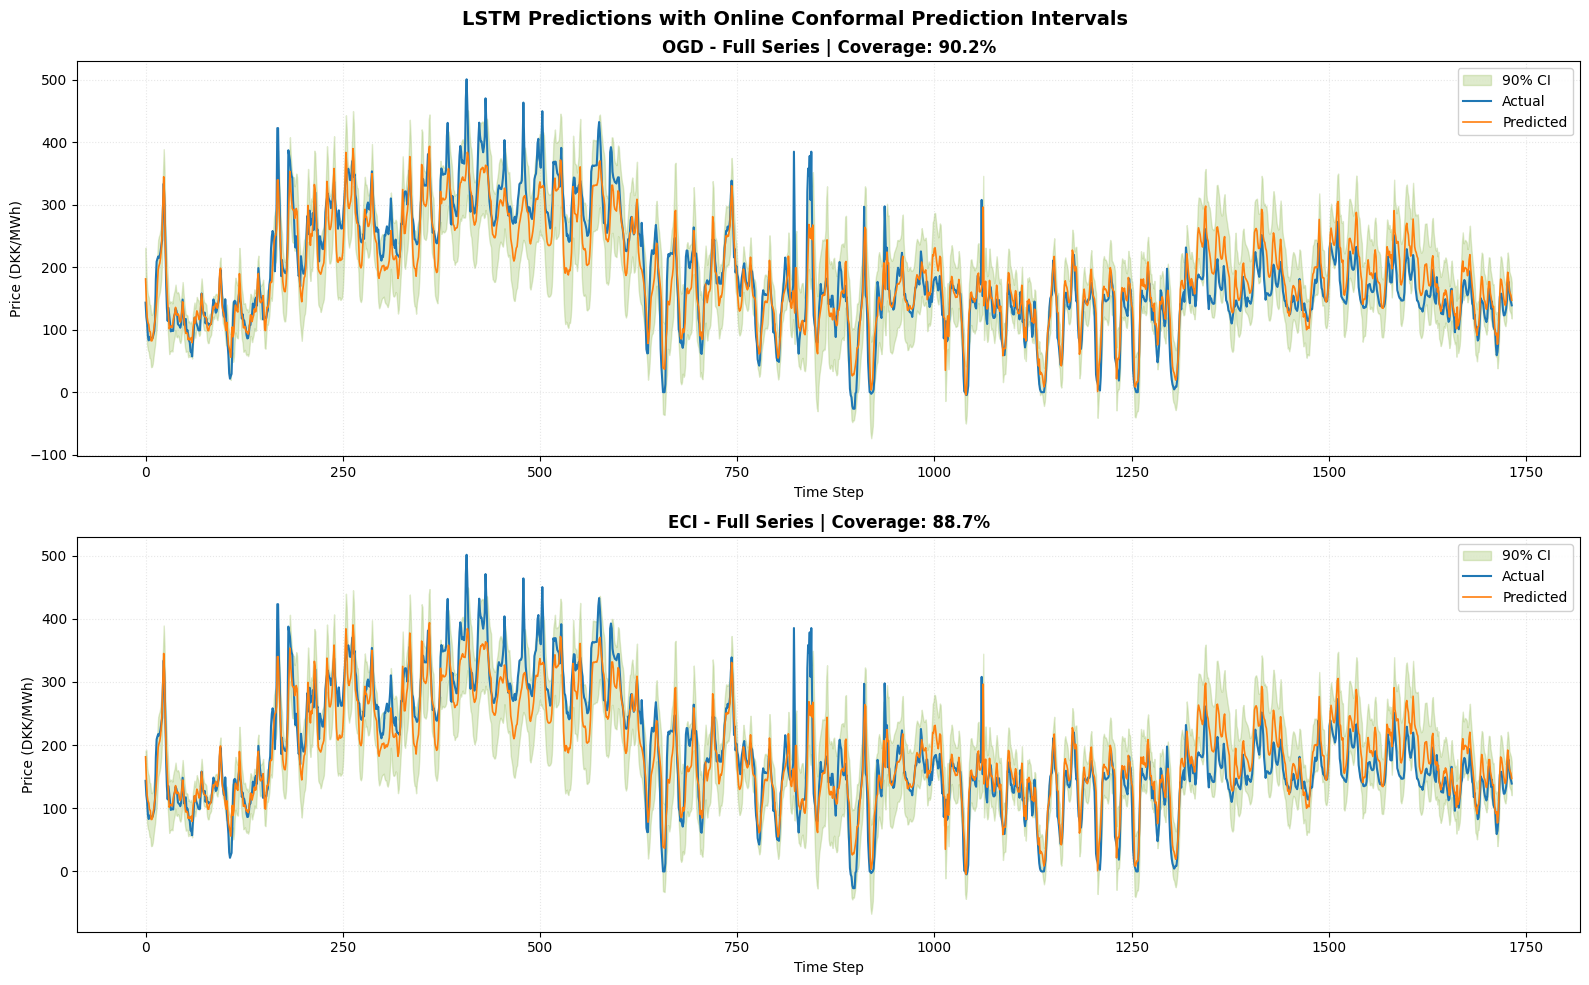

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def get_intervals_from_history(predictions, threshold_history, q_init):
    """Reconstruct intervals from threshold history.
    
    threshold_history[t] contains q AFTER the update at time t.
    The interval at time t uses the q value BEFORE the update (i.e., from t-1).
    """
    # At t=0, we use q_init; at t>0, we use q from previous step
    q_values = [q_init] + list(threshold_history[:-1])
    q_values = np.array(q_values)
    lowers = predictions - q_values
    uppers = predictions + q_values
    return lowers, uppers

# Get intervals for both methods
ogd_lower, ogd_upper = get_intervals_from_history(predictions_unscaled, ogd.threshold_history, q_init=50)
eci_lower, eci_upper = get_intervals_from_history(predictions_unscaled, eci_basic.threshold_history, q_init=10)

# Define zoom window
zoom_start, zoom_end = 500, 700
time_steps = np.arange(len(predictions_unscaled))

# Create 2x1 subplot
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

def plot_ci(ax, time_range, lower, upper, preds, actuals, title, ci_color, pred_color):
    """Plot confidence interval on a given axis."""
    t = time_range
    ax.fill_between(t, lower[t], upper[t], alpha=0.25, color=ci_color, label='90% CI')
    ax.plot(t, actuals[t], linewidth=1.5, label='Actual', alpha=1.0)
    ax.plot(t, preds[t], linewidth=1.2, label='Predicted', alpha=1.0)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Step', fontsize=10)
    ax.set_ylabel('Price (DKK/MWh)', fontsize=10)
    ax.legend(loc='upper right', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle=':')

# OGD plot
ogd_coverage = ogd.get_coverage_rate()
plot_ci(axes[0], range(len(predictions_unscaled)), ogd_lower, ogd_upper,
        predictions_unscaled, actuals_unscaled,
        f'OGD - Full Series | Coverage: {ogd_coverage:.1%}', 
        ci_color="#82B03AFF", pred_color="#A50000")

# ECI plot  
eci_coverage = eci_basic.get_coverage_rate()
plot_ci(axes[1], range(len(predictions_unscaled)), eci_lower, eci_upper,
        predictions_unscaled, actuals_unscaled,
        f'ECI - Full Series | Coverage: {eci_coverage:.1%}', 
        ci_color="#82B03AFF", pred_color='#BC4749')

plt.suptitle('LSTM Predictions with Online Conformal Prediction Intervals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('lstm_conformal_intervals.png', dpi=300)
plt.show()